In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import scipy.stats as ss
from sklearn.preprocessing import minmax_scale 
import re
import warnings
warnings.filterwarnings('ignore')
import sweetviz as sv
sns.set(style="darkgrid")
pd.options.display.show_dimensions=False
pd.options.display.width = 80
pd.options.display.max_colwidth = 10
pd.options.display.max_columns = 80
pd.set_option('display.max_rows',None)

Citation:
juntarawijit, chudchawal (2014-2017). Pesticide and lung cancer. figshare. Dataset. https://doi.org/10.6084/m9.figshare.12356270.v5

Data was analyzed prior to this analysis and presented in research paper: Pesticide exposure and lung cancer risk: A case-control study in Nakhon Sawan, Thailand : Teera Kangkhetkron and Chudchawal Juntarawijit (2020)

The dataset contains 68 columns which record responses of participants in Nakhon Sawan province, Thailand by in-person questionaire. 233 lung cancer cases, and 458 healthy neighbours matched for gender, and age (±5 years) were questioned about pesticides and other types of environmental exposures.  Demographic data, distance to nearest farm land, air pollution exposures, cigarette smoking habits were collected. Many of the features were recorded in multiple forms such as yes or no, number of days, total per year, etc.                                                          Many cells were left empty when the field is a quantity following a no exposure response. 
 
Cigarette smoking was recorded in 5 different columns.  Here we will look at Cigarette_number and CigSmoke_status.                                                 
For full descriptions refer to the Data Dictionary: https://figshare.com/articles/dataset/Pesticide_and_lung_cancer/12356270/5?file=39615298

Target: ID:  Float data. .0 as control, no lung cancer and .(1-9) as lung cancer

LungCA: Lung cancer status of responders: 0  as control and 1 as having lung cancer

Cigarette_number: the number of cigarettes smoked per day

CigSmoke_status: Tobacco status of responders, 1 refers those who have never smoked a cigarette, 2 refers to ex-smoker, 3 refers to
current smoker

age_group: Responders in each group; 
1 refers to those with age less than or equal to 54, 
2 refer to those with age 55-64 yr, 
3 refer to those with age 65-74 yr, 
4 refer to those with age 75 yr or more

Herbicide_days, Number_Days_Insecticides_Use_432 and Number_Days_Fungicides_Use_433 are cummulative columns calculated as number of days * number of years. 

Problem statement:   Lung cancer has long been a cause of human mortality with cigarette smoking being a known contributor. Airborne envirnomental exposures are a daily occurrence across the globe, such as, exhaust from industry and vehicles, vapors from cooking and cleaning or the use of pesticides, fungicides and herbicides across farmlands. The goal of this analysis is to determine if other environmental exposures increase the incident lung cancers. 

In [35]:
lung_cancer = pd.read_csv('https://raw.githubusercontent.com/catorchid/ds-tools-project/main/Dataset%20pesticide%20and%20lung%20cancer.csv')
lung_cancer.sample(10)

,ID,LungCA,Gender,age,age_group,status,education,Occupation,Residency,Distances,Cooking_fumes,Air_Pollution_Exposure,CigSmoke1,CigSmoke2,Cigarette_total,Cigarette_year,Cigarette_number,CigSmoke_status,Herbicides,Herbicides_year,Herbicide_year_group,Herbicide_day,Number_Days_Herbicides_Use_Quartile_431,Insecticides_Use_432,Number_Years_Insecticides_Use_432,Number_Years_Insecticides_Use_Group_432,Number_Days_Insecticides_Use_432,Number_Days_Insecticides_Use_Quartile_432,Fungicides_Use_433,Number_Years_Fungticides_Use_433,Number_Years_Fungicides_Use_Group_433,Number_Days_Fungicides_Use_433,Number_Days_Fungicides_Use_Quartile_433,Glyphosate_use,Glyphosate_days,Paraquat_use,Paraquat_days,two_four_Dichlorophenoxy_use,two_four_Dichlorophenoxy_days,Butachlor_use,Butachlor_Days,Propanil_use,Propanil_days,Alachlor_use,Alachlor_days,Endosalfan_use,Endosalfan_days,Dieldrin_use,Dieldrin_days,DDT_use,DDT_days,Chlorpylifos_use,Chlorpylifos_days,Folidol_use,Folidol_days,Mevinphos_use,Mevinphos_days,Carbaryl_Savins_use,Carbaryl_Savins_days,Carbofuran_use,Carbofuran_days,Abamectin_use,Abamectin_days,Armure_Propiconazole_use,Armure_Propiconazole_days,Metal_aldehyde_use,Metal_aldehyde_days,Morphology_Group
216,73.0,1,1,77,4,3,1,1,3,3,2,1,1,0,0,0,0,1,1,20,2,600,3,1,30,2,460,2,0,,,,,1,160,1,160,0,0,0,0,0,0,0,0,0,0,1,720,0,,0,,0,,0,,0,,0,,1,200,0,,0,,3
138,47.0,1,0,62,2,2,1,1,3,3,2,1,0,1,5475,5,2,2,0,,,,,0,,,,,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,1,400,1
84,29.0,1,0,79,4,3,1,2,3,1,1,1,0,2,73000,20,10,2,0,,,,,0,,,,,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,1
211,71.1,0,0,63,2,2,1,1,3,3,1,1,1,0,0,0,0,1,0,,,,,0,,,,,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,0
357,122.1,0,1,63,2,2,1,1,3,3,2,0,1,0,0,0,0,1,0,,,,,0,,,,,0,,,,,1,33,1,33,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,0
142,48.1,0,0,65,3,2,1,1,3,3,2,0,1,0,0,0,0,1,1,20,2,600,3,0,,,,,0,,,,,1,80,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,0
567,227.1,0,1,74,3,2,1,2,3,1,2,1,0,1,219000,60,10,2,1,40,3,1680,4,1,40,3,1600,4,0,,,,,1,160,1,160,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,1,1680,0,,0,,0,,0,,0,,0,,0
73,25.1,0,0,82,4,3,1,2,3,1,2,0,1,0,0,0,0,1,0,,,,,0,,,,,0,,,,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,0
44,15.2,0,0,68,3,3,1,2,3,1,1,1,1,0,0,0,0,1,1,20,2,80,1,0,,,,,0,,,,,1,1440,1,640,1,640,0,0,0,0,0,0,0,0,0,,0,,0,,0,,0,,0,,0,,0,,0,,0,,0
666,287.1,0,1,74,3,2,1,1,3,2,2,1,1,0,0,0,0,1,1,30,2,600,3,1,30,2,280,2,0,,,,,0,0,0,0,0,0,0,0,1,400,0,0,0,0,0,,1,32,0,,0,,0,,1,270,0,,0,,0,,0,,0


In [4]:
lung_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 68 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   ID                                         680 non-null    float64
 1   LungCA                                     680 non-null    int64  
 2   Gender                                     680 non-null    int64  
 3   age                                        680 non-null    int64  
 4   age_group                                  680 non-null    int64  
 5   status                                     680 non-null    int64  
 6   education                                  680 non-null    int64  
 7   Occupation                                 680 non-null    int64  
 8   Residency                                  680 non-null    int64  
 9   Distances                                  680 non-null    int64  
 10  Cooking_fumes             

Although isna returns 0 for all columns, there are empty cells. Regex to replace empty cells with 0. All empty cells refer to a quantity where the reponse to exposure is no.  We can safely apply 0 here as it follows there would be no # of cigarettes smoked or days in which an exposure occurred. 

In [5]:
lung_cancer = lung_cancer.replace(r'^\s*$', 0, regex=True)
lung_cancer.sample(10)

,ID,LungCA,Gender,age,age_group,status,education,Occupation,Residency,Distances,Cooking_fumes,Air_Pollution_Exposure,CigSmoke1,CigSmoke2,Cigarette_total,Cigarette_year,Cigarette_number,CigSmoke_status,Herbicides,Herbicides_year,Herbicide_year_group,Herbicide_day,Number_Days_Herbicides_Use_Quartile_431,Insecticides_Use_432,Number_Years_Insecticides_Use_432,Number_Years_Insecticides_Use_Group_432,Number_Days_Insecticides_Use_432,Number_Days_Insecticides_Use_Quartile_432,Fungicides_Use_433,Number_Years_Fungticides_Use_433,Number_Years_Fungicides_Use_Group_433,Number_Days_Fungicides_Use_433,Number_Days_Fungicides_Use_Quartile_433,Glyphosate_use,Glyphosate_days,Paraquat_use,Paraquat_days,two_four_Dichlorophenoxy_use,two_four_Dichlorophenoxy_days,Butachlor_use,Butachlor_Days,Propanil_use,Propanil_days,Alachlor_use,Alachlor_days,Endosalfan_use,Endosalfan_days,Dieldrin_use,Dieldrin_days,DDT_use,DDT_days,Chlorpylifos_use,Chlorpylifos_days,Folidol_use,Folidol_days,Mevinphos_use,Mevinphos_days,Carbaryl_Savins_use,Carbaryl_Savins_days,Carbofuran_use,Carbofuran_days,Abamectin_use,Abamectin_days,Armure_Propiconazole_use,Armure_Propiconazole_days,Metal_aldehyde_use,Metal_aldehyde_days,Morphology_Group
223,75.1,0,1,42,1,2,1,2,2,3,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308,103.2,0,0,70,3,2,1,2,2,3,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2000,1,2000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
367,125.2,0,1,72,3,2,1,2,3,3,1,1,0,2,54750,30,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
187,63.1,0,1,85,4,1,1,2,3,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,11.2,0,0,55,2,2,2,2,3,1,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
258,87.0,1,0,52,1,2,1,1,3,3,2,0,0,1,306600,42,20,2,1,42,3,672,3,1,35,3,560,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,560,0,0,0,0,4
208,70.1,0,0,69,3,2,1,1,3,3,1,1,0,2,71175,39,5,2,1,39,3,936,3,0,0,0,0,0,0,0,0,0,0,1,1440,0,0,0,0,1,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
659,285.0,1,0,57,2,2,1,1,2,1,2,0,1,0,0,0,0,1,1,25,2,2000,0,1,25,2,600,3,0,0,0,0,0,1,45,0,0,1,90,0,0,1,30,0,0,1,120,0,0,1,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370,3
143,48.2,0,0,56,2,2,1,1,3,3,2,0,0,2,73000,20,10,2,1,20,2,600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,120,1,360,1,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
479,174.0,1,0,72,3,2,1,1,3,3,2,1,1,0,0,0,0,1,1,20,2,600,3,0,0,0,0,0,0,0,0,0,0,1,1200,1,1200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


<Axes: >

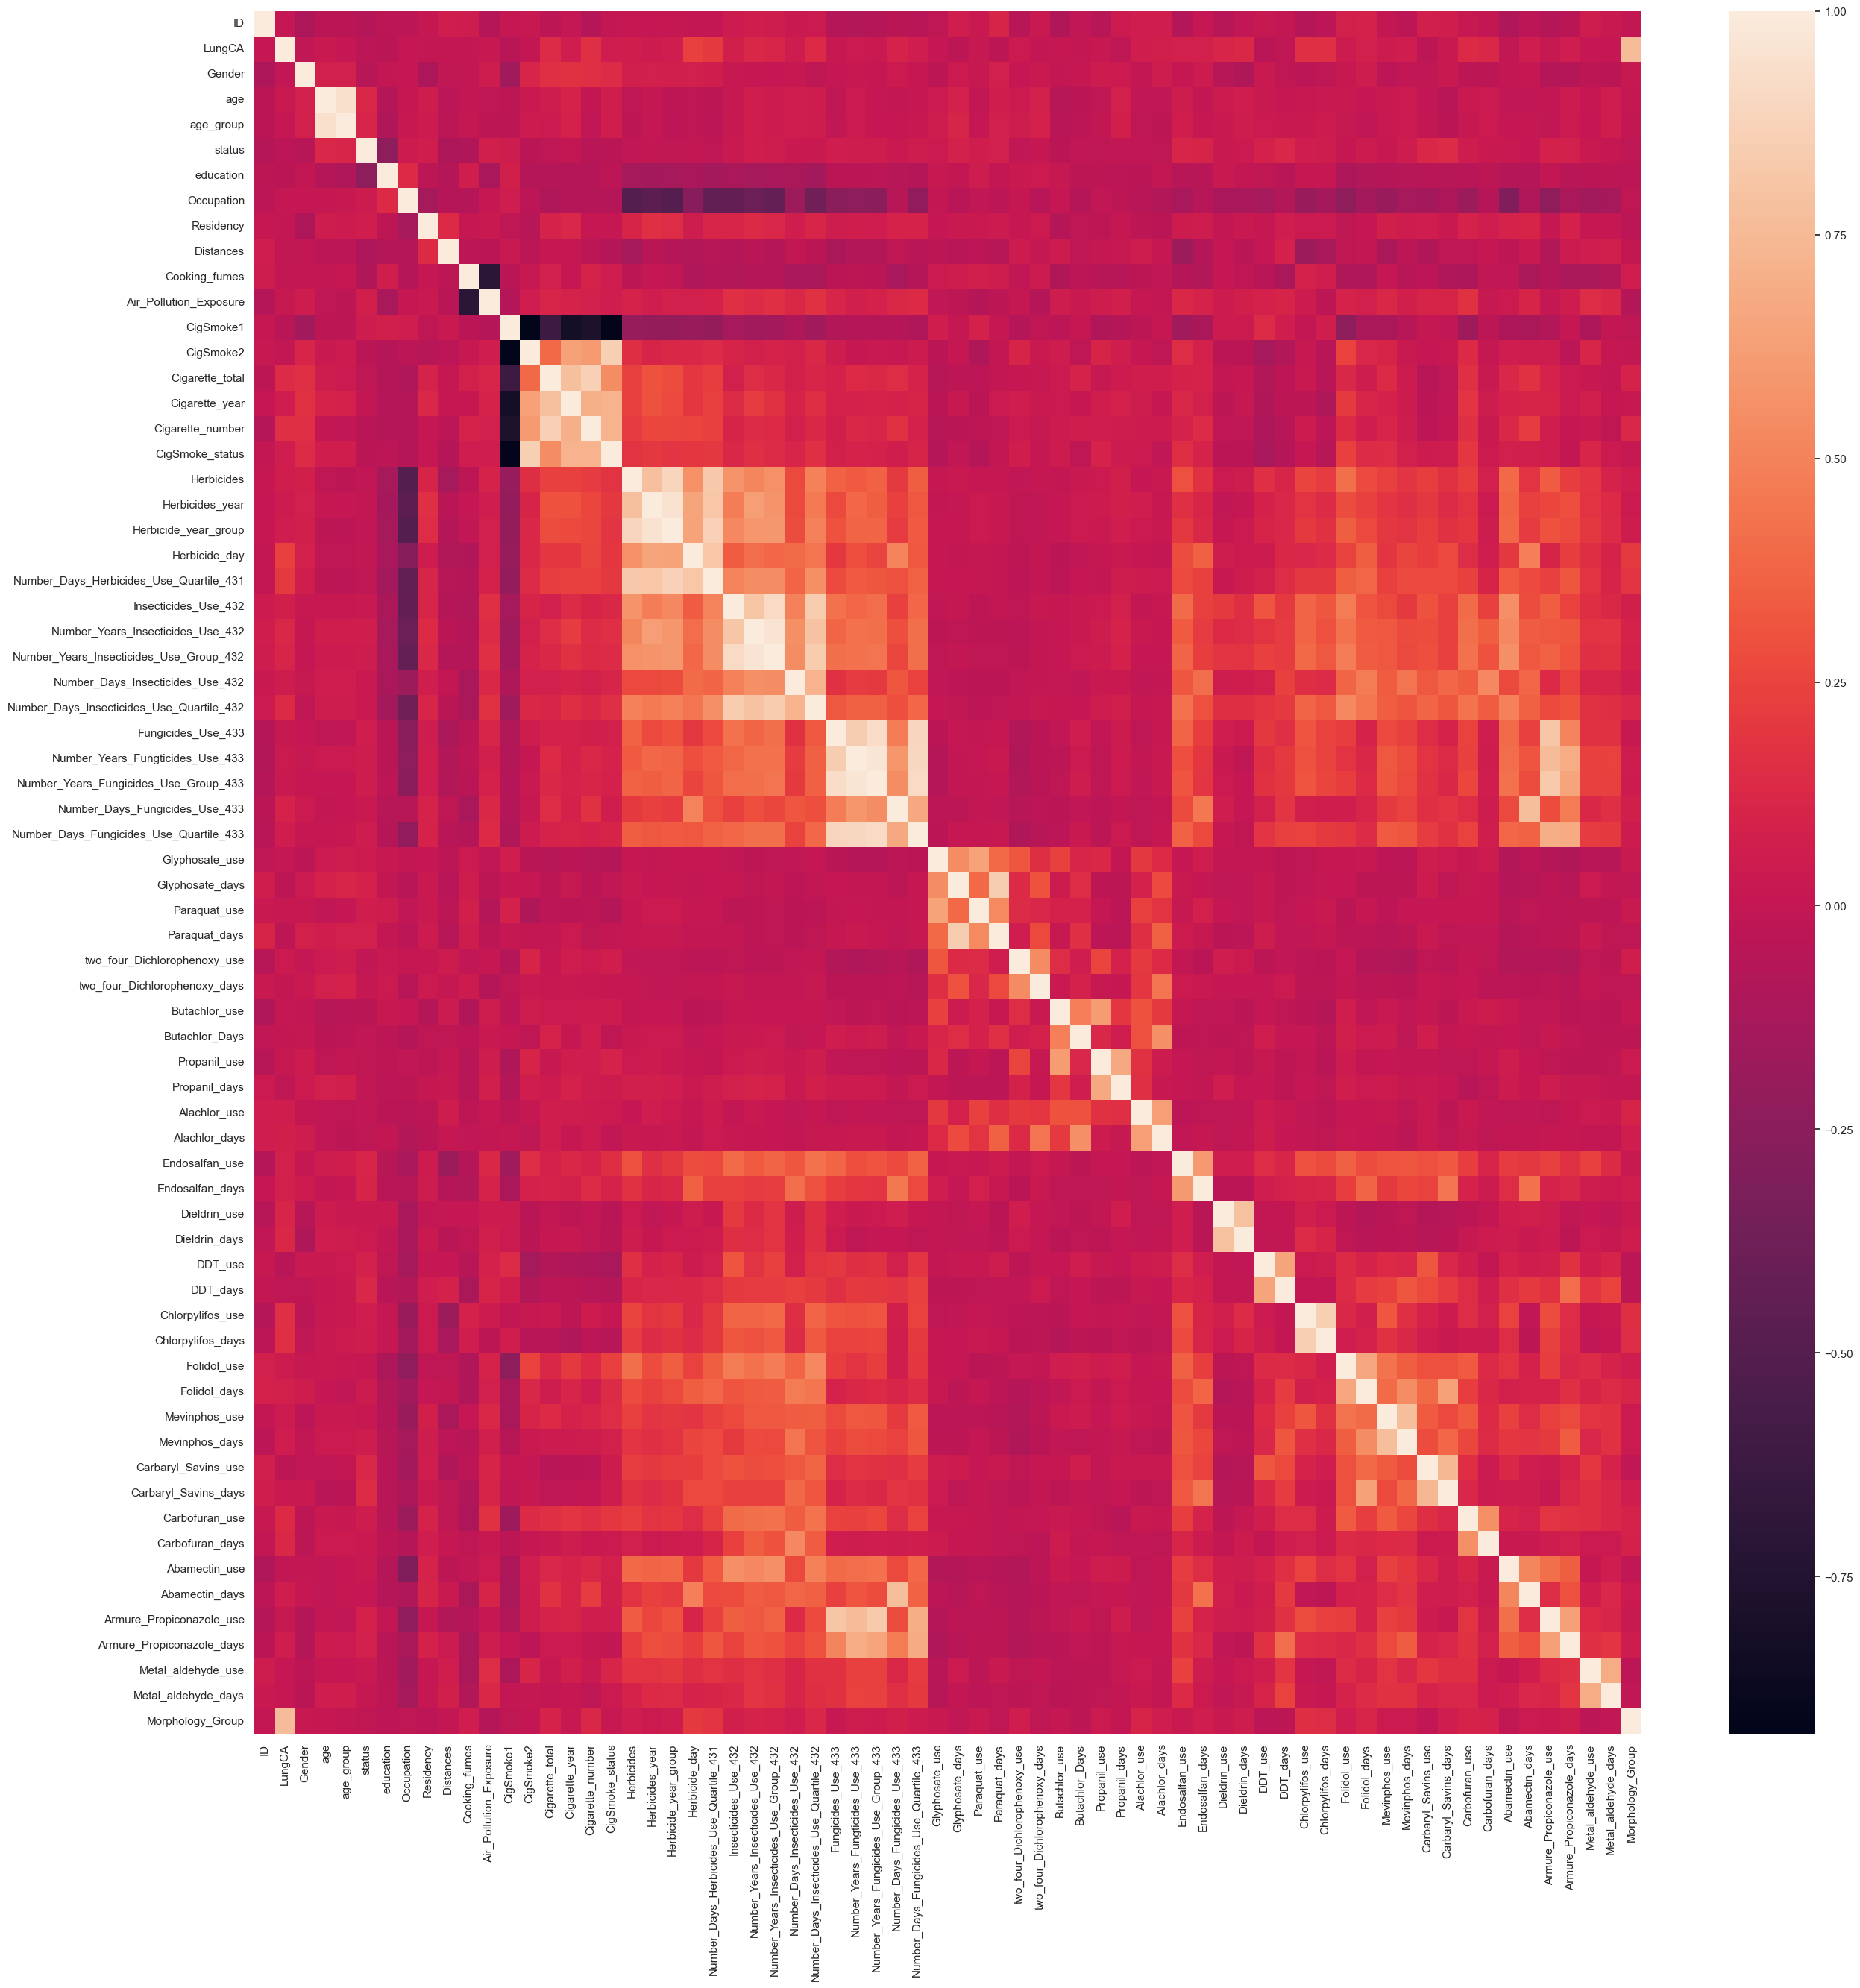

In [6]:
# heatmap containing all 68 features.  Not very useful but we can see some areas of high correlation do exist
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(30, 30))
coeff=lung_cancer.corr()
sns.heatmap(coeff)

In [7]:
lung_cancer.describe()

,ID,LungCA,Gender,age,age_group,status,education,Occupation,Residency,Distances,Cooking_fumes,Air_Pollution_Exposure,CigSmoke1,CigSmoke2,Cigarette_year,CigSmoke_status,Herbicides,Insecticides_Use_432,Fungicides_Use_433,Glyphosate_use,Glyphosate_days,Paraquat_use,Paraquat_days,two_four_Dichlorophenoxy_use,two_four_Dichlorophenoxy_days,Butachlor_use,Butachlor_Days,Propanil_use,Propanil_days,Alachlor_use,Alachlor_days,Endosalfan_use,Endosalfan_days,Dieldrin_use,DDT_use,Chlorpylifos_use,Folidol_use,Mevinphos_use,Carbaryl_Savins_use,Carbofuran_use,Abamectin_use,Armure_Propiconazole_use,Metal_aldehyde_use,Morphology_Group
count,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...,680.00...
mean,127.80...,0.342647,0.589706,65.600000,2.627941,2.069118,1.101471,1.436765,2.650000,1.994118,1.679412,0.485294,0.650000,0.529412,10.352941,1.448529,0.510294,0.448529,0.170588,0.413235,300.29...,0.354412,229.48...,0.170588,73.364706,0.055882,14.964706,0.047059,8.917647,0.063235,39.944118,0.116176,71.850000,0.064706,0.073529,0.102941,0.152941,0.055882,0.070588,0.125000,0.197059,0.117647,0.063235,0.898529
std,83.800673,0.474944,0.492249,10.794724,1.002845,0.440497,0.338929,0.496350,0.658802,0.935297,0.467046,0.500152,0.477321,0.780291,17.160135,0.667131,0.500262,0.497710,0.376426,0.492777,654.43...,0.478687,582.35...,0.376426,301.64...,0.229863,126.74...,0.211921,60.095302,0.243565,249.02...,0.320672,333.85...,0.246187,0.261196,0.304106,0.360196,0.229863,0.256324,0.330962,0.398070,0.322427,0.243565,1.632692
min,1.000000,0.000000,0.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,57.175000,0.000000,0.000000,58.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,114.15...,0.000000,1.000000,66.000000,3.000000,2.000000,1.000000,1.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,189.02...,1.000000,1.000000,74.000000,3.000000,2.000000,1.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,1.000000,15.250000,2.000000,1.000000,1.000000,0.000000,1.000000,338.00...,1.000000,160.00...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,292.20...,1.000000,1.000000,98.000000,4.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000,1.000000,1.000000,2.000000,70.000000,3.000000,1.000000,1.000000,1.000000,1.000000,5760.0...,1.000000,5760.0...,1.000000,3600.0...,1.000000,1920.0...,1.000000,660.00...,1.000000,3600.0...,1.000000,5460.0...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [8]:
# New df containing columns of interest
lung_cancer_trunc = lung_cancer[['ID','LungCA','age_group','Gender','CigSmoke_status','Cigarette_number','Cigarette_total','Cooking_fumes','Air_Pollution_Exposure','Herbicide_day',
'Number_Days_Insecticides_Use_432','Number_Days_Fungicides_Use_433','Glyphosate_days','Paraquat_days','two_four_Dichlorophenoxy_days',
'Butachlor_Days','Propanil_days','Alachlor_days','Endosalfan_days','Dieldrin_days','DDT_days','Chlorpylifos_days','Folidol_days',
'Mevinphos_days','Carbaryl_Savins_days','Carbofuran_days','Abamectin_days','Armure_Propiconazole_days','Metal_aldehyde_days']]

In [9]:
lung_cancer_trunc.drop(['ID'], axis=1, inplace = True)
lung_cancer_trunc=lung_cancer_trunc.astype(int)
lung_cancer_trunc['ID']=lung_cancer['ID']

In [10]:
lung_cancer_trunc.sample(5)

,LungCA,age_group,Gender,CigSmoke_status,Cigarette_number,Cigarette_total,Cooking_fumes,Air_Pollution_Exposure,Herbicide_day,Number_Days_Insecticides_Use_432,Number_Days_Fungicides_Use_433,Glyphosate_days,Paraquat_days,two_four_Dichlorophenoxy_days,Butachlor_Days,Propanil_days,Alachlor_days,Endosalfan_days,Dieldrin_days,DDT_days,Chlorpylifos_days,Folidol_days,Mevinphos_days,Carbaryl_Savins_days,Carbofuran_days,Abamectin_days,Armure_Propiconazole_days,Metal_aldehyde_days,ID
74,0,4,0,1,0,0,2,0,0,0,0,960,240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.2
68,0,1,1,3,10,98550,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23.2
13,0,4,1,1,0,0,2,1,600,600,0,528,0,528,0,0,0,0,0,0,0,0,0,600,0,0,0,0,5.1
2,0,3,1,1,0,0,2,0,90,135,0,0,0,0,0,0,0,0,0,0,0,135,0,0,0,0,0,0,1.2
661,0,1,0,1,0,0,2,0,90,130,0,1600,1600,0,0,0,0,0,0,0,0,135,0,0,0,0,0,0,285.2


In [11]:
lung_cancer_trunc.dtypes

LungCA                                int32
age_group                             int32
Gender                                int32
CigSmoke_status                       int32
Cigarette_number                      int32
Cigarette_total                       int32
Cooking_fumes                         int32
Air_Pollution_Exposure                int32
Herbicide_day                         int32
Number_Days_Insecticides_Use_432      int32
Number_Days_Fungicides_Use_433        int32
Glyphosate_days                       int32
Paraquat_days                         int32
two_four_Dichlorophenoxy_days         int32
Butachlor_Days                        int32
Propanil_days                         int32
Alachlor_days                         int32
Endosalfan_days                       int32
Dieldrin_days                         int32
DDT_days                              int32
Chlorpylifos_days                     int32
Folidol_days                          int32
Mevinphos_days                  

Contribution of cigarette smoking to lung cancer development by age group.   As the average number of cigarettes smoked per day increases, so does the number of lung cancer cases. There is a correlation between increased smoking and lung cancer.  Age may also be a factor but further investigation would be needed. 

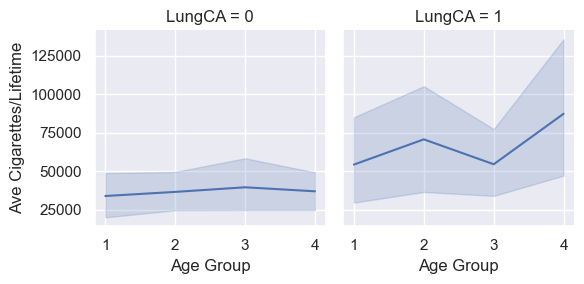

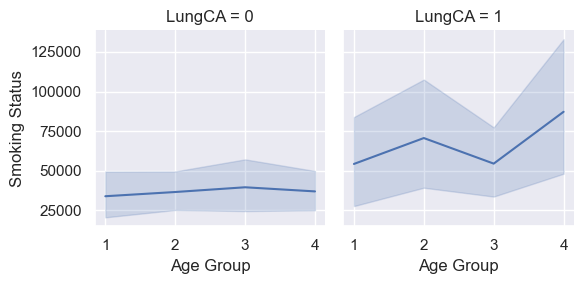

In [12]:
palette = sns.cubehelix_palette(light=.6, n_colors=2)
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Cigarette_total", 
    palette=palette, height=3,
    col='LungCA'
)
g1 = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Cigarette_total", 
    palette=palette, height=3,
    col='LungCA'
)
g.set_axis_labels("Age Group", "Ave Cigarettes/Lifetime")
g1.set_axis_labels("Age Group", "Smoking Status")

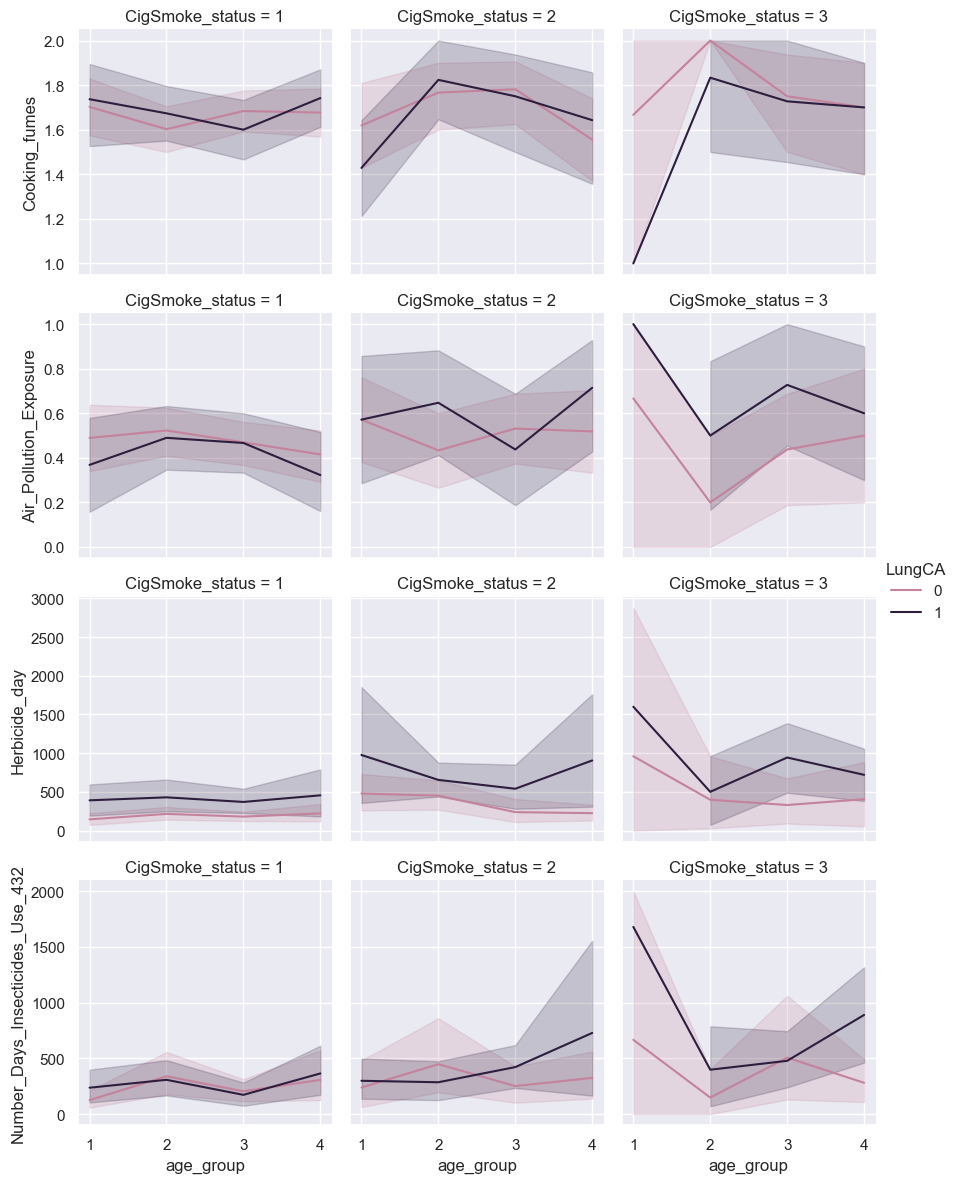

In [13]:
# melt the dataframe so all the "Y Val Row *" values are in the same column
dfmelt1 = pd.melt(lung_cancer_trunc, id_vars=['age_group', 'CigSmoke_status', 'Cigarette_total','LungCA'], 
                     value_vars=['Cooking_fumes', 'Air_Pollution_Exposure', 'Herbicide_day',
                     'Number_Days_Insecticides_Use_432'],
                     var_name="variable", value_name="value")

# make the relplot, limiting the sharey flag to each row
gm = sns.relplot(data=dfmelt1, row="variable", y="value", x="age_group", 
                 col="CigSmoke_status", hue="LungCA", kind="line",
                 palette=palette, height=3,facet_kws={"sharey":"row"})

# pull the "Y Val Row *" label from each graph title onto the row y label
# this assumes the current default behavior seaborn.relplot for graph titling
for row in gm.axes:
    for ax in row:
        title = ax.title.get_text()
        ax.set_title(title.split(" | ")[1])
    row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))

Observations: Air pollutions appears to be a contributing factor to lung cancer when coupled with cigarette smoking.  As general terms, herbicides appear to be a lung cancer risk across all groups and ages.  Insecticides may increase the risk for smokers. Thankfully, cooking fumes do not appear to cause any additional risk.  We won't need to resort to raw eggs in our milk and uncooked veggies. 

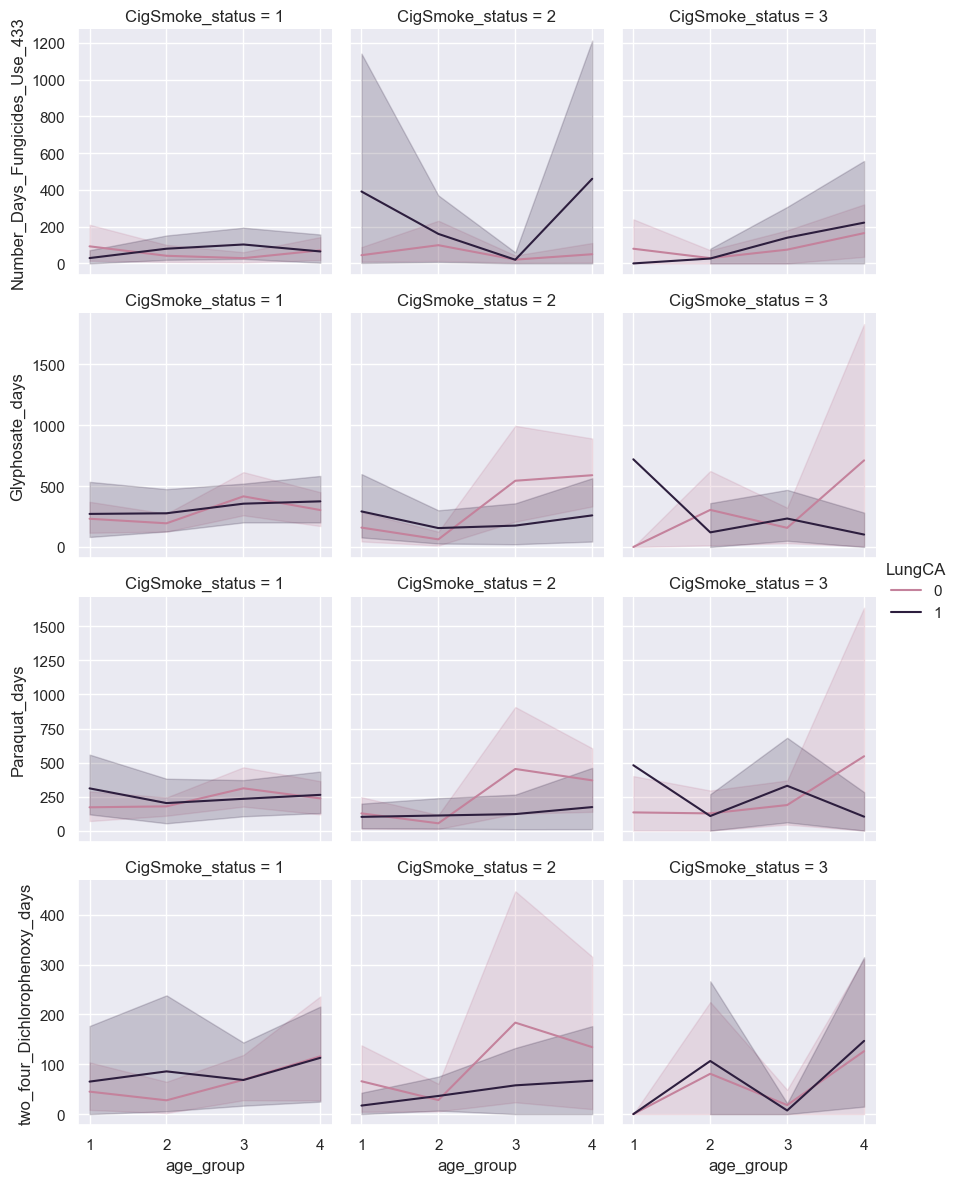

In [14]:
dfmelt2 = pd.melt(lung_cancer_trunc, id_vars=['age_group', 'CigSmoke_status', 'Cigarette_total', 'LungCA'], 
                     value_vars=['Number_Days_Fungicides_Use_433',
                     'Glyphosate_days','Paraquat_days','two_four_Dichlorophenoxy_days'],
                     var_name="variable", value_name="value")
gm2 = sns.relplot(data=dfmelt2, row="variable", y="value", x="age_group", 
                 col="CigSmoke_status", hue="LungCA", kind="line",
                 palette=palette, height=3,facet_kws={"sharey":"row"})
for row in gm2.axes:
    for ax in row:
        title = ax.title.get_text()
        ax.set_title(title.split(" | ")[1])
    row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))

Observations: Largely inconclusive but the general fungicide catagory may increase risk of lung cancer. 

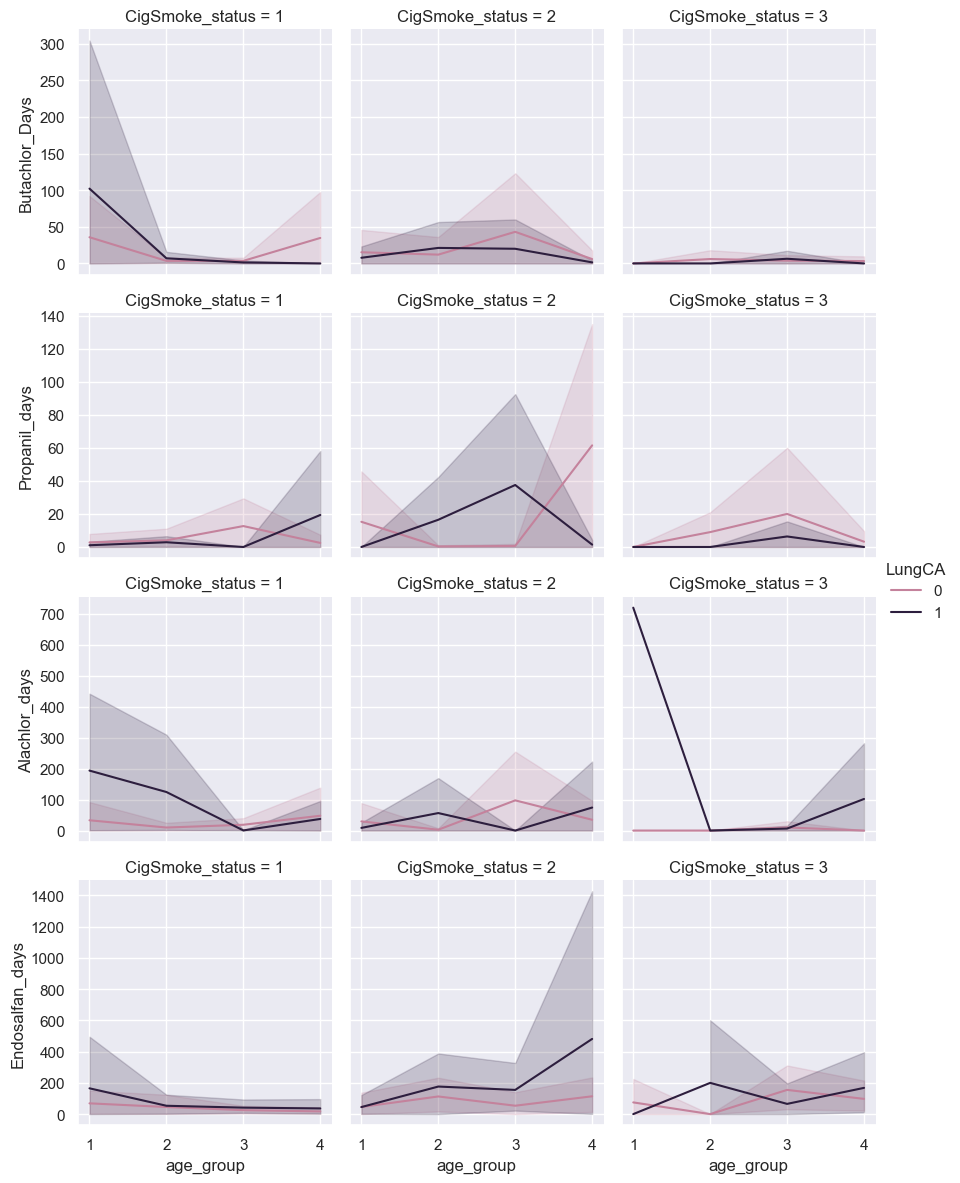

In [15]:
dfmelt3 = pd.melt(lung_cancer_trunc, id_vars=['age_group', 'CigSmoke_status','Cigarette_total', 'LungCA'], 
                     value_vars=['Butachlor_Days','Propanil_days','Alachlor_days','Endosalfan_days'],
                     var_name="variable", value_name="value")
gm3 = sns.relplot(data=dfmelt3, row="variable", y="value", x="age_group", 
                 col="CigSmoke_status", hue="LungCA", kind="line",
                 palette=palette, height=3,facet_kws={"sharey":"row"})
for row in gm3.axes:
    for ax in row:
        title = ax.title.get_text()
        ax.set_title(title.split(" | ")[1])
    row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))

Observations: Alachlor and Endosalfan might increase risk. 

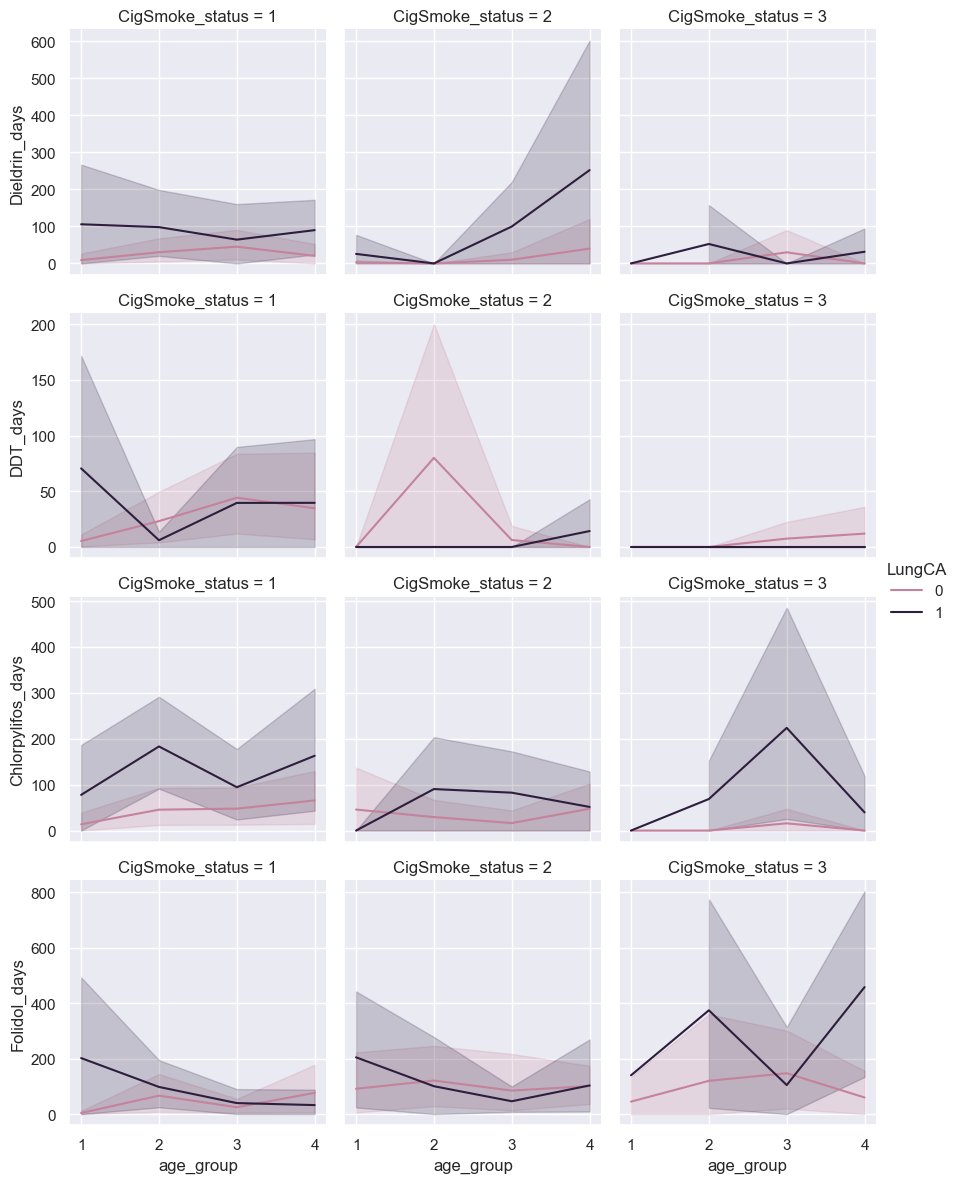

In [16]:
dfmelt4 = pd.melt(lung_cancer_trunc, id_vars=['age_group', 'CigSmoke_status', 'Cigarette_total','LungCA'], 
                     value_vars=['Dieldrin_days','DDT_days','Chlorpylifos_days','Folidol_days'],
                     var_name="variable", value_name="value")
gm4 = sns.relplot(data=dfmelt4, row="variable", y="value", x="age_group", 
                 col="CigSmoke_status", hue="LungCA", kind="line",
                 palette=palette, height=3,facet_kws={"sharey":"row"})
for row in gm4.axes:
    for ax in row:
        title = ax.title.get_text()
        ax.set_title(title.split(" | ")[1])
    row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))

Observations: Dieldrin, and Chlorpylifos appear to increase lung cancer risk.  Foidol is a possible risk. 

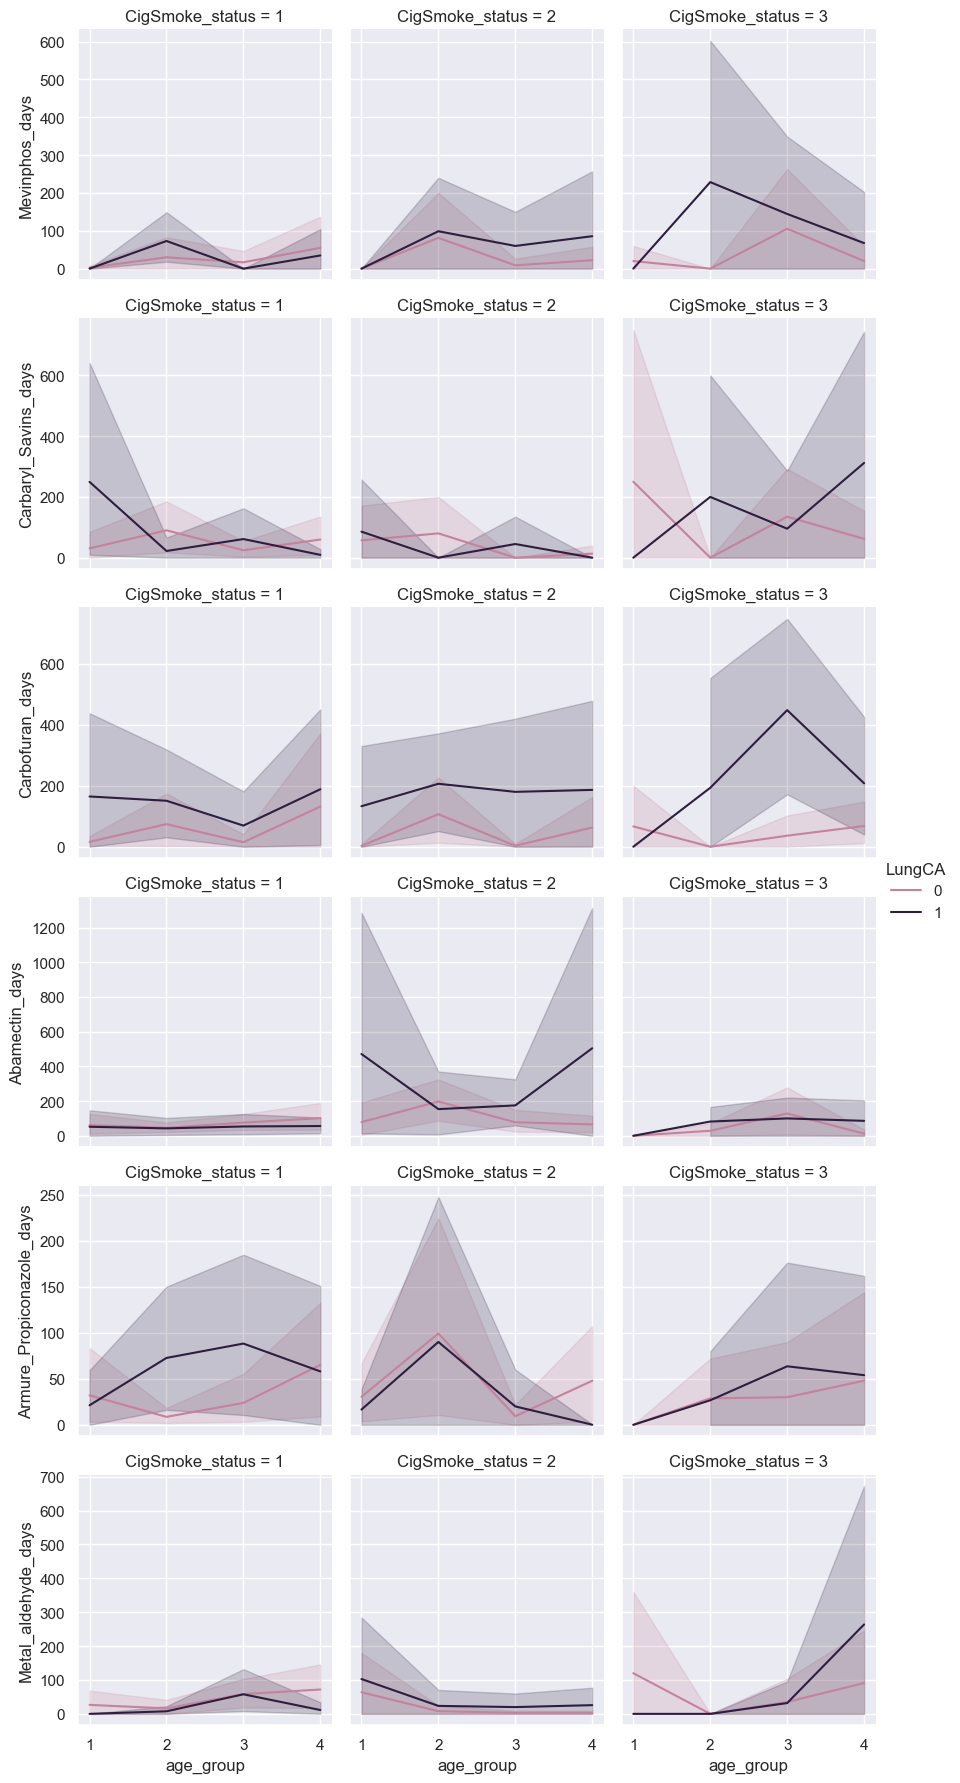

In [17]:
dfmelt5 = pd.melt(lung_cancer_trunc, id_vars=['age_group', 'CigSmoke_status','Cigarette_total', 'LungCA'], 
                     value_vars=['Mevinphos_days','Carbaryl_Savins_days','Carbofuran_days','Abamectin_days',
                     'Armure_Propiconazole_days','Metal_aldehyde_days'],
                     var_name="variable", value_name="value")
gm5 = sns.relplot(data=dfmelt5, row="variable", y="value", x="age_group", 
                 col="CigSmoke_status", hue="LungCA", kind="line",
                 palette=palette, height=3,facet_kws={"sharey":"row"})
for row in gm5.axes:
    for ax in row:
        title = ax.title.get_text()
        ax.set_title(title.split(" | ")[1])
    row[0].set_ylabel(title.split(" | ")[0].replace("variable = ", ""))

Observations: Carbofuran (insecticide used world-wide on crops) and Mevinphos (insecticide used mainly on vegetables) both appear strongly correlated. The other 4 may be risk factors when combined with smoking and/or age. 

create a new column for total_exposures which contains the sum of all exposures excluding cigarettes

In [18]:
lung_cancer_trunc['Total_exposures'] = lung_cancer_trunc.iloc[:,7:9].sum(axis=1)
lung_cancer_trunc.sample(5)

,LungCA,age_group,Gender,CigSmoke_status,Cigarette_number,Cigarette_total,Cooking_fumes,Air_Pollution_Exposure,Herbicide_day,Number_Days_Insecticides_Use_432,Number_Days_Fungicides_Use_433,Glyphosate_days,Paraquat_days,two_four_Dichlorophenoxy_days,Butachlor_Days,Propanil_days,Alachlor_days,Endosalfan_days,Dieldrin_days,DDT_days,Chlorpylifos_days,Folidol_days,Mevinphos_days,Carbaryl_Savins_days,Carbofuran_days,Abamectin_days,Armure_Propiconazole_days,Metal_aldehyde_days,ID,Total_exposures
402,0,1,0,1,0,0,2,0,480,260,120,0,0,0,0,0,0,840,0,80,560,0,0,60,0,60,120,0,139.1,480
47,0,2,1,1,0,0,2,0,0,0,120,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120,0,16.2,0
545,0,3,0,1,0,0,1,1,0,0,0,0,0,600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208.1,1
73,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25.1,0
429,0,1,1,2,10,109500,1,1,800,360,0,144,144,0,0,0,0,0,0,0,0,360,0,0,0,0,0,0,154.1,801


In [19]:
lung_cancer_trunc.sample(5)

,LungCA,age_group,Gender,CigSmoke_status,Cigarette_number,Cigarette_total,Cooking_fumes,Air_Pollution_Exposure,Herbicide_day,Number_Days_Insecticides_Use_432,Number_Days_Fungicides_Use_433,Glyphosate_days,Paraquat_days,two_four_Dichlorophenoxy_days,Butachlor_Days,Propanil_days,Alachlor_days,Endosalfan_days,Dieldrin_days,DDT_days,Chlorpylifos_days,Folidol_days,Mevinphos_days,Carbaryl_Savins_days,Carbofuran_days,Abamectin_days,Armure_Propiconazole_days,Metal_aldehyde_days,ID,Total_exposures
321,1,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,108.0,0
381,0,3,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130.1,1
172,0,3,0,1,0,0,2,0,640,1400,0,160,0,0,160,0,0,640,0,0,0,120,0,0,0,640,0,0,58.1,640
663,0,3,1,1,0,0,1,1,1600,1200,0,0,0,0,0,0,0,0,0,0,1200,0,0,0,0,0,0,0,286.1,1601
291,1,2,0,2,10,54750,2,0,960,600,120,80,0,80,0,0,0,0,0,0,0,138,0,0,0,0,120,0,98.0,960


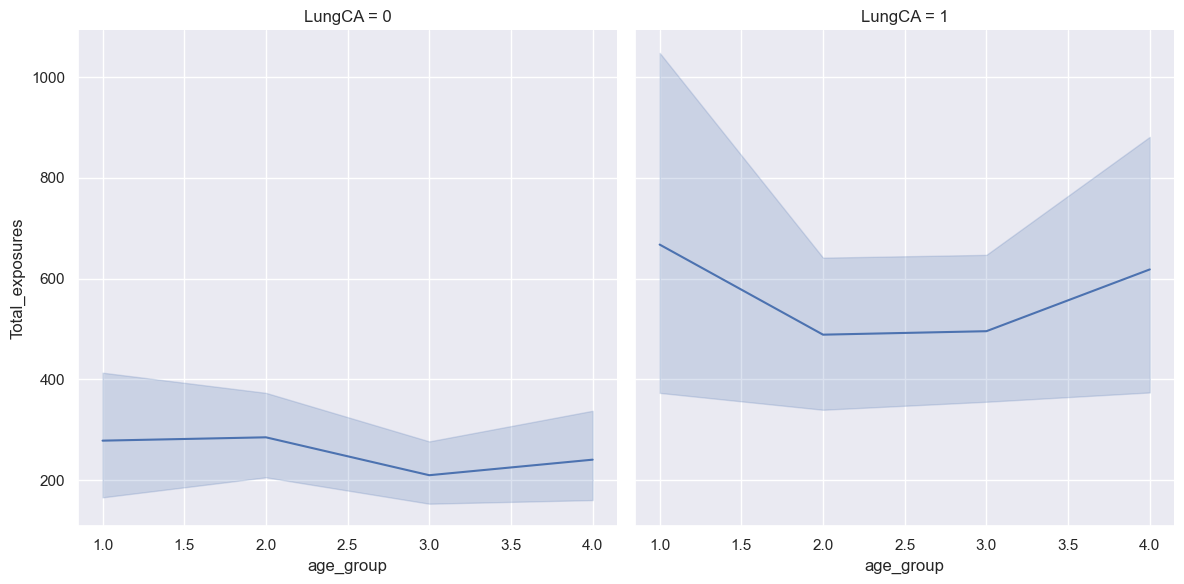

In [20]:
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Total_exposures", 
    palette=palette, height=6,
    col='LungCA'
)

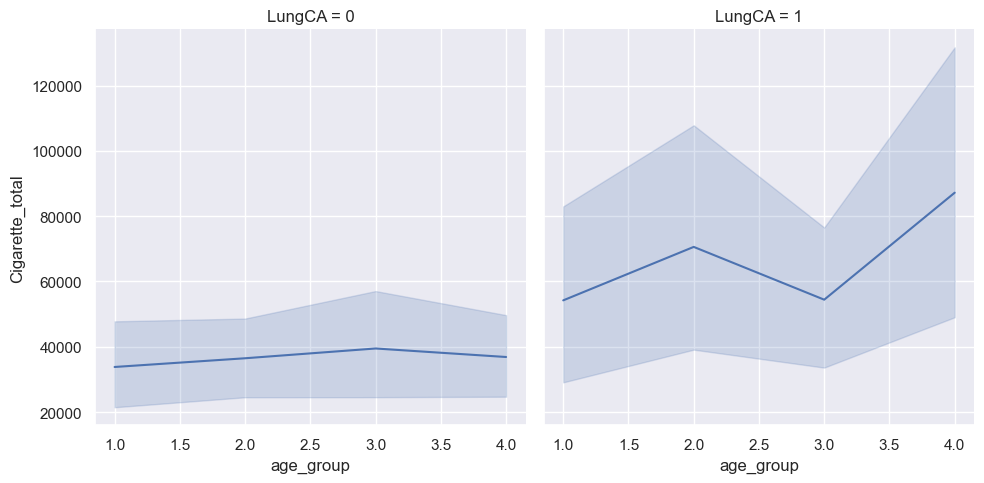

In [21]:

g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    y='Cigarette_total', x="age_group", 
    palette=palette, height=5,
    col='LungCA'
)

In [22]:
lung_cancer_trunc=pd.get_dummies(lung_cancer_trunc, columns=['CigSmoke_status'])
lung_cancer_trunc.sample(5)

,LungCA,age_group,Gender,Cigarette_number,Cigarette_total,Cooking_fumes,Air_Pollution_Exposure,Herbicide_day,Number_Days_Insecticides_Use_432,Number_Days_Fungicides_Use_433,Glyphosate_days,Paraquat_days,two_four_Dichlorophenoxy_days,Butachlor_Days,Propanil_days,Alachlor_days,Endosalfan_days,Dieldrin_days,DDT_days,Chlorpylifos_days,Folidol_days,Mevinphos_days,Carbaryl_Savins_days,Carbofuran_days,Abamectin_days,Armure_Propiconazole_days,Metal_aldehyde_days,ID,Total_exposures,CigSmoke_status_1,CigSmoke_status_2,CigSmoke_status_3
435,1,4,1,10,73000,1,1,840,900,0,0,0,0,0,0,0,960,0,0,0,840,0,0,0,0,0,960,157.0,841,False,False,True
232,0,2,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78.1,0,True,False,False
534,0,2,0,0,0,2,0,640,0,0,0,0,0,0,0,520,0,0,0,0,0,0,0,0,0,0,640,201.1,640,True,False,False
343,0,2,1,10,156950,2,0,1800,0,0,160,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,115.2,1800,False,True,False
116,0,2,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39.2,0,True,False,False


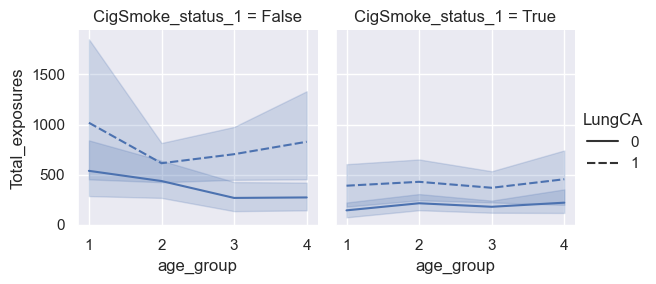

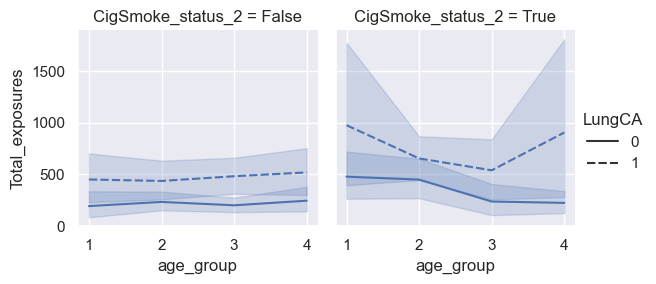

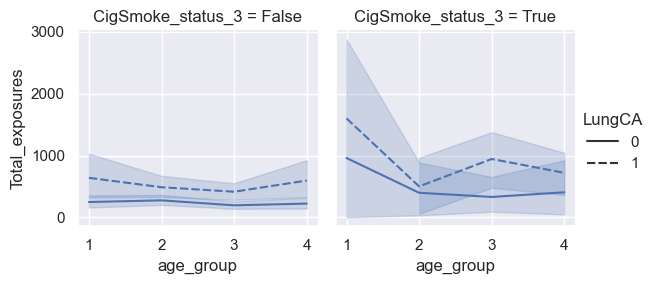

In [23]:
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Total_exposures", 
    palette=palette, height=3,
    col='CigSmoke_status_1',style='LungCA'
)
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Total_exposures", 
    palette=palette, height=3,
    col='CigSmoke_status_2',style='LungCA'
)
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Total_exposures", 
    palette=palette, height=3,
    col='CigSmoke_status_3',style='LungCA'
)

In [24]:
import scipy.stats
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['CigSmoke_status_1'])

SignificanceResult(statistic=-0.04839871711967859, pvalue=0.2074887175539296)

In [25]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['CigSmoke_status_2'])

SignificanceResult(statistic=0.01719333047841422, pvalue=0.6544740809244423)

In [26]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['CigSmoke_status_3'])

SignificanceResult(statistic=0.05242858352345508, pvalue=0.1720663765884992)

In [27]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['Total_exposures'])

SignificanceResult(statistic=0.16666044194943433, pvalue=1.2506550626089275e-05)

In [28]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['Carbofuran_days'])

SignificanceResult(statistic=0.142542298547309, pvalue=0.00019203626445637946)

In [29]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['Chlorpylifos_days'])

SignificanceResult(statistic=0.16508915624391762, pvalue=1.5129066334868171e-05)

In [30]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer_trunc['Cigarette_total'])

SignificanceResult(statistic=0.07566217423721208, pvalue=0.04858382893908292)

In [31]:
scipy.stats.spearmanr(lung_cancer_trunc['LungCA'], lung_cancer['age'])

SignificanceResult(statistic=0.02534721112336145, pvalue=0.5093408746407553)

create new column Cig_plus_exposures the sum of total cigarettes smoked and total_exposures

In [32]:
lung_cancer_trunc['Cig_plus_exposures'] = lung_cancer_trunc['Total_exposures']+lung_cancer_trunc['Cigarette_total']
lung_cancer_trunc.sample(5)

,LungCA,age_group,Gender,Cigarette_number,Cigarette_total,Cooking_fumes,Air_Pollution_Exposure,Herbicide_day,Number_Days_Insecticides_Use_432,Number_Days_Fungicides_Use_433,Glyphosate_days,Paraquat_days,two_four_Dichlorophenoxy_days,Butachlor_Days,Propanil_days,Alachlor_days,Endosalfan_days,Dieldrin_days,DDT_days,Chlorpylifos_days,Folidol_days,Mevinphos_days,Carbaryl_Savins_days,Carbofuran_days,Abamectin_days,Armure_Propiconazole_days,Metal_aldehyde_days,ID,Total_exposures,CigSmoke_status_1,CigSmoke_status_2,CigSmoke_status_3,Cig_plus_exposures
282,1,3,1,3,43800,2,1,540,750,0,1008,0,84,0,0,0,0,0,0,0,130,0,0,960,0,0,0,95.0,541,False,True,False,44341
346,0,2,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116.2,1,True,False,False,1
256,0,1,0,0,0,2,0,0,0,0,240,360,120,0,0,360,0,0,0,0,0,0,0,0,0,0,0,86.1,0,True,False,False,0
265,0,3,1,0,0,2,0,0,0,0,5760,2880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,89.1,0,True,False,False,0
140,0,2,0,20,73000,2,1,0,800,0,0,0,0,0,0,0,0,0,0,400,0,0,0,0,400,0,0,47.2,1,False,True,False,73001


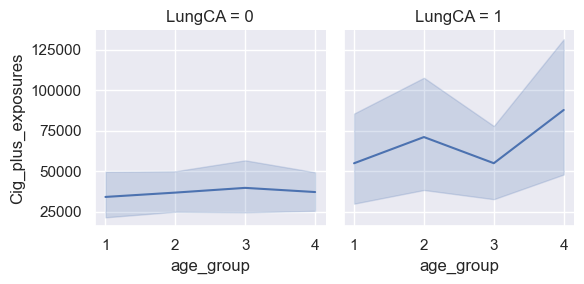

In [33]:
g = sns.relplot(
    data=lung_cancer_trunc, kind="line",
    x="age_group", y="Cig_plus_exposures", 
    palette=palette, height=3,
    col='LungCA'
)


In [34]:
scipy.stats.spearmanr(lung_cancer_trunc['Cig_plus_exposures'], lung_cancer_trunc['LungCA'])

SignificanceResult(statistic=0.1064766750025258, pvalue=0.005446470559759582)